### Loading libraries

In [1]:
library(tidyverse)
library(tidymodels)
library(gridExtra)

── Attaching packages ────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ───────────────────────────────────────────────── tidymodels 0.1.3 ──

✔ broom        0.7.6      ✔ rsample      0.0.9 
✔ dials        0.0.9      ✔ tune         0.1.5 
✔ infer        0.5.4      ✔ workflows    0.2.2 
✔ modeldata    0.1.0      ✔ workflowsets 0.0.2 
✔ parsnip      0.1.5      ✔ yardstick    0.0.8 
✔ recipes      0.1.16     

── Conflicts ──────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::la

### Utility functions

In [2]:
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

### Loading data

In [8]:
path <- ""

names <- read.table(paste(path, "spotify-names.txt", sep = ""),header = TRUE)
songs <- read.table(paste(path, "spotify-extr.txt", sep = ""),
                    sep = " ", header = TRUE) %>%
    as_tibble() %>%
    mutate(name = names$x,
           key = factor(key),
           mode = factor(mode),
           pop.class = factor(pop.class)) %>%
    relocate(c(pop.class, popularity)) %>%
    update_role(name)
    #relocate(c(mode, key, name), .after=last_col())

songs.quant <- songs %>% select(popularity:tempo)

head(songs)

pop.class popularity valence year acousticness danceability duration energy
1 C         25         0.647   1975 0.4490       0.376        298840   0.827 
2 B         42         0.150   2008 0.8990       0.508        236800   0.169 
3 A         65         0.423   2007 0.0185       0.470        301093   0.878 
4 C         36         0.302   1995 0.0384       0.176        142200   0.980 
5 C         38         0.828   1994 0.5310       0.705        187800   0.625 
6 A         68         0.489   2018 0.3710       0.856        324189   0.694 
  instrumentalness liveness loudness speechiness tempo   mode key
1 7.88e-03         0.466     -7.604  0.3990      170.475 1    B  
2 1.12e-05         0.136    -11.332  0.0553      107.477 1    Ab 
3 8.39e-02         0.276     -5.576  0.0377      150.093 0    B  
4 5.52e-01         0.237     -3.154  0.0721      172.566 1    B  
5 7.73e-06         0.348    -11.963  0.0639       97.831 0    G  
6 0.00e+00         0.109     -4.393  0.1690      122.080 1    D  
  name                            
1 William Tell Overture           
2 Everything I Know               
3 Rest My Chemistry               
4 Stutter                         
5 Wanna Do My Thing               
6 Mona Lisa (feat. Kendrick Lamar)

## Exploratory statistics

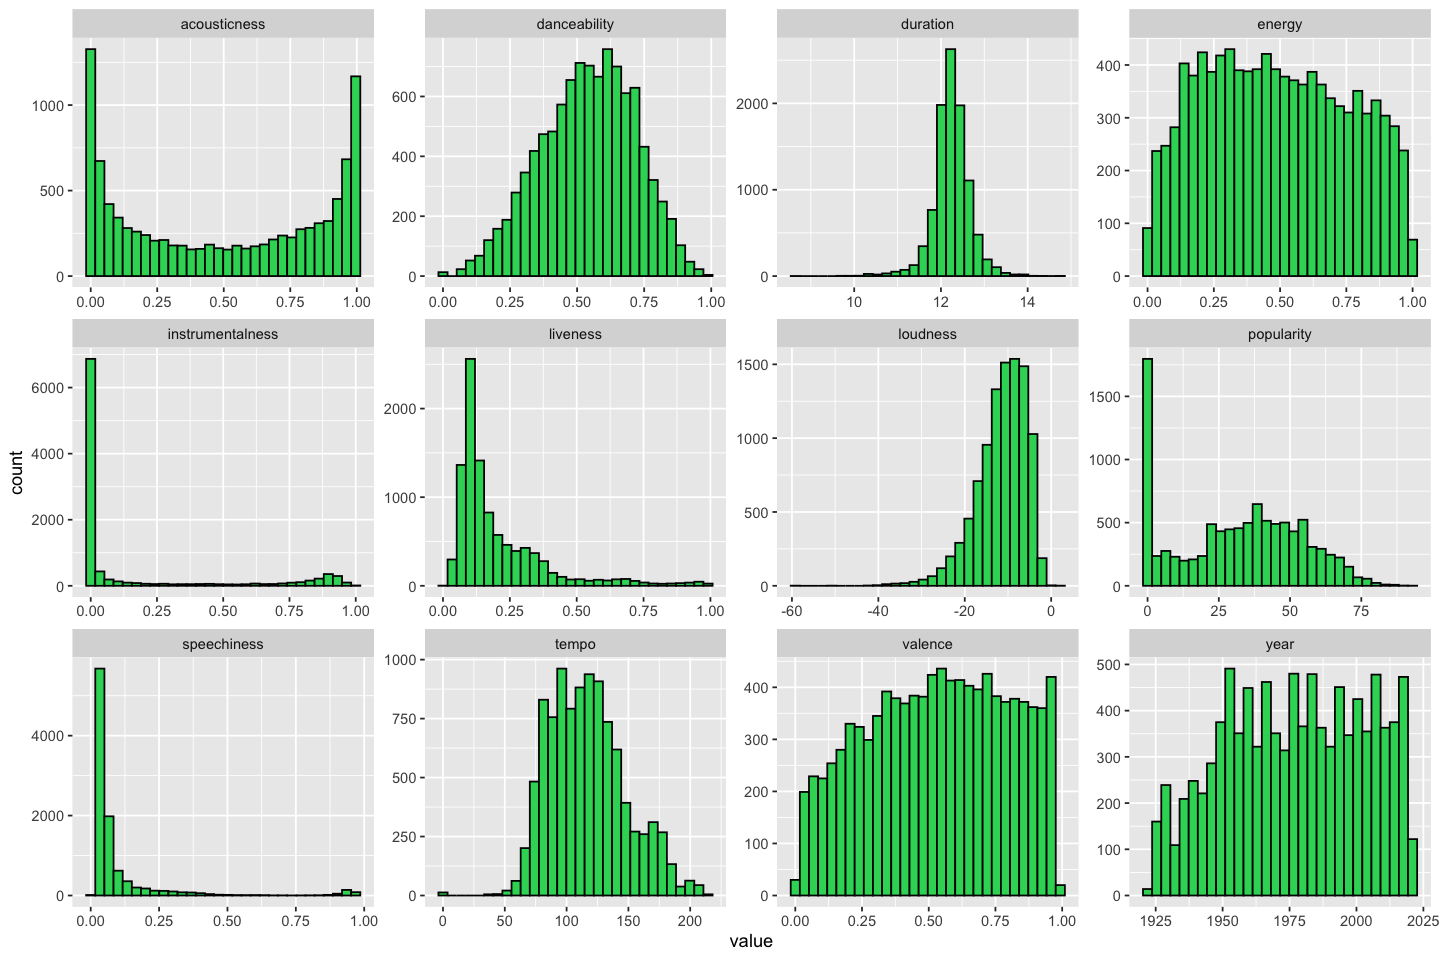

In [276]:
fig(12,8)
songs.quant %>%
    #filter(speechiness < .75) %>%
    mutate(duration=log(duration)) %>%
    pivot_longer(cols=everything(), names_to='variable', values_to='value') %>%
ggplot() +
    geom_histogram(aes(value), fill='#2FD565', color='#000000', bins=30) +
    facet_wrap(~variable, scales='free')

In [184]:
songs %>%
    filter(speechiness > .75 & pop.class=='A') #%>% ggplot() + geom_bar(stat='count', aes(pop.class))

pop.class popularity valence year acousticness danceability duration energy
1 A         67         0.556   2020 0.978        0.773        56808    0.398 
  instrumentalness liveness loudness speechiness tempo  mode key
1 0                0.413    -11.494  0.871       56.284 1    D  
  name             
1 BOOTY CALL (skit)

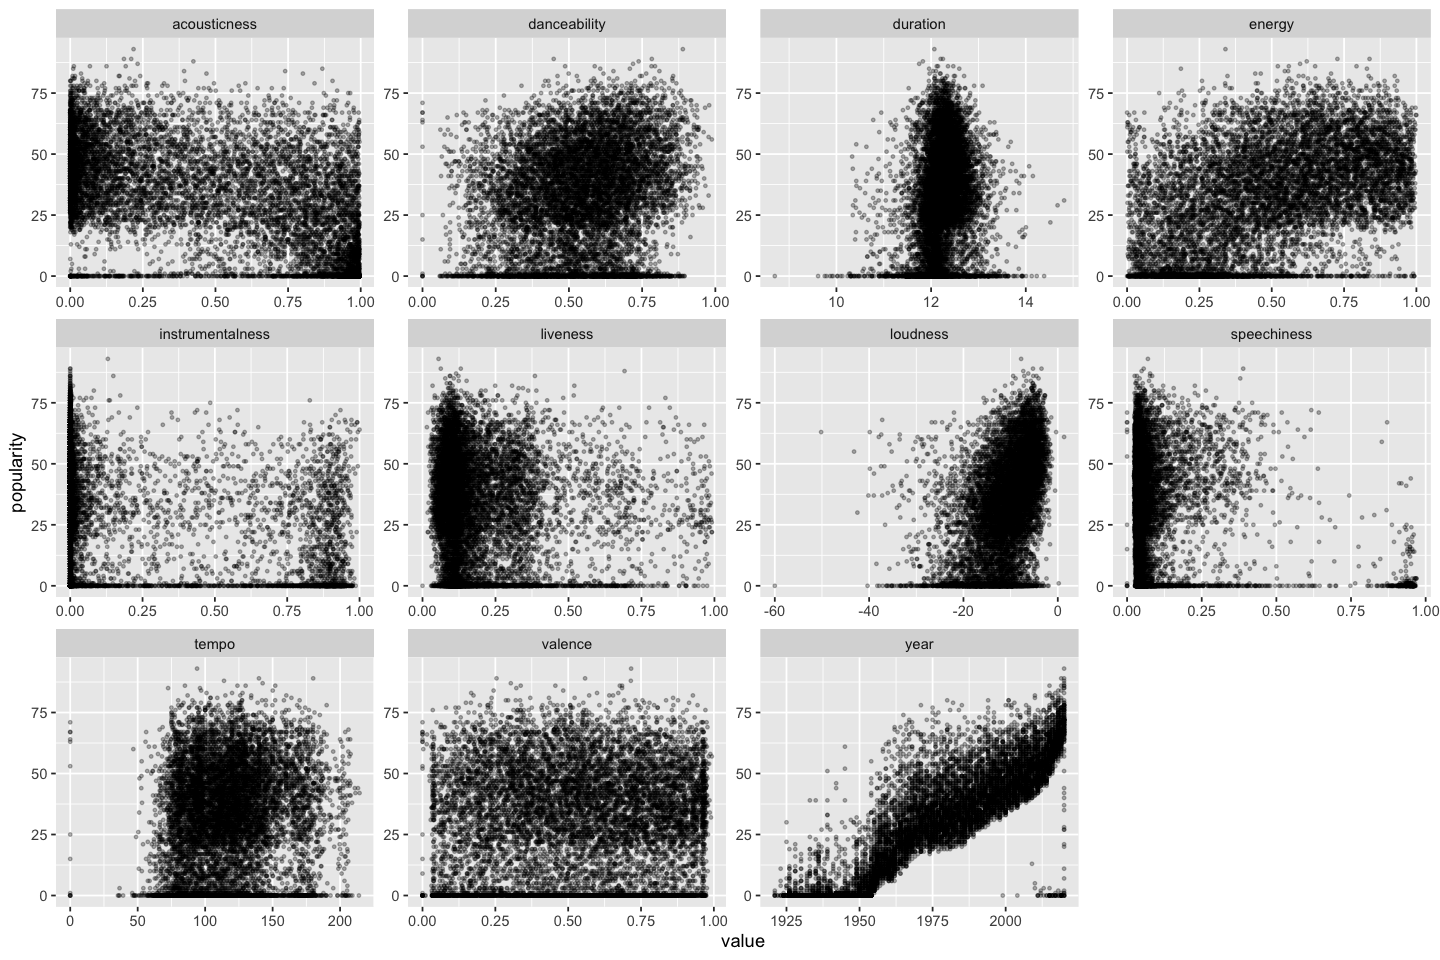

In [10]:
fig(15,10)
songs.quant %>%
    mutate(duration=log(duration)) %>%
    pivot_longer(cols=!popularity, names_to='variable', values_to='value') %>%
ggplot() +
    geom_point(aes(value, popularity), size=.7, alpha=.3) + 
    facet_wrap(~variable, scales='free')

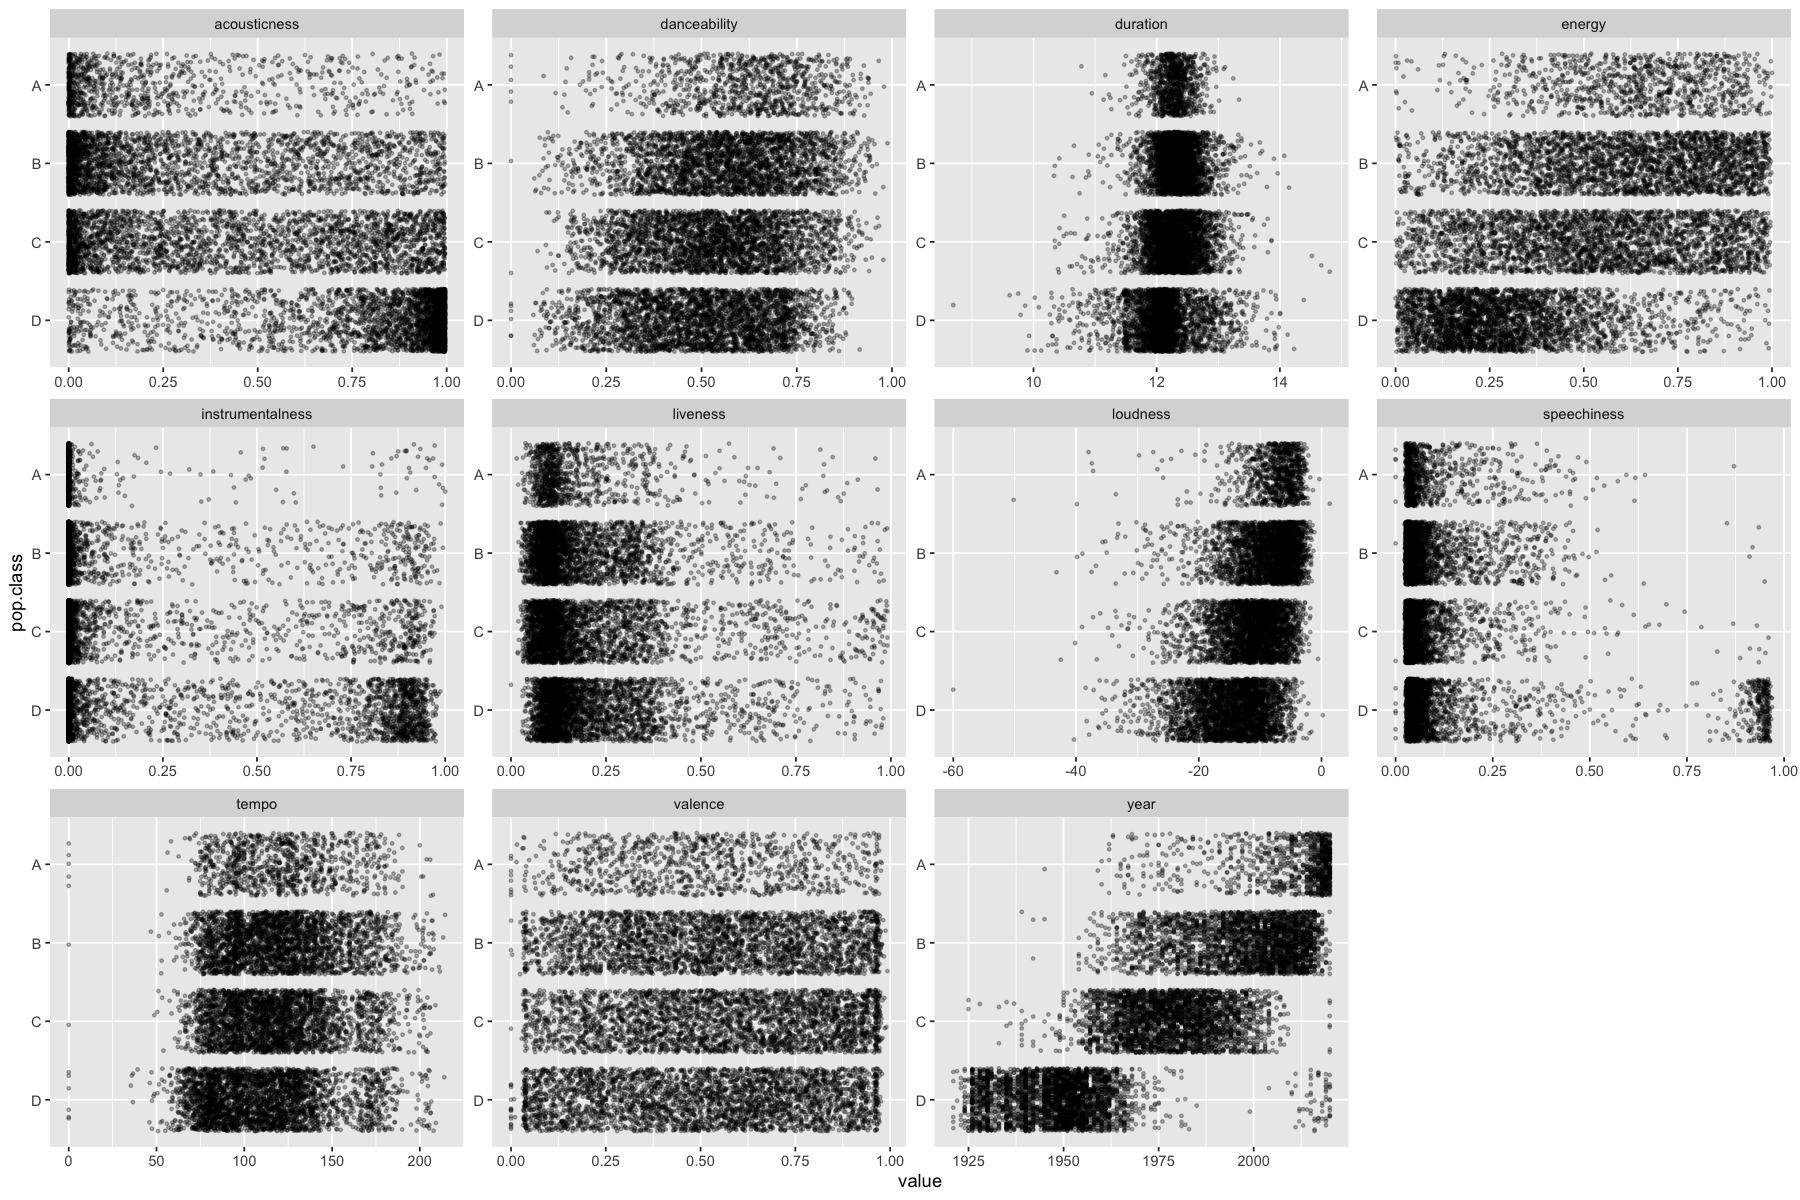

In [49]:
fig(15,10)
songs %>%
    mutate(duration=log(duration)) %>%
    select(c(pop.class, valence:tempo)) %>%
    pivot_longer(cols=!pop.class, names_to='variable', values_to='value') %>%
ggplot() +
    geom_jitter(aes(value, pop.class), size=.7, alpha=.3) + 
    facet_wrap(~variable, scales='free') +
    scale_y_discrete(limits=rev)

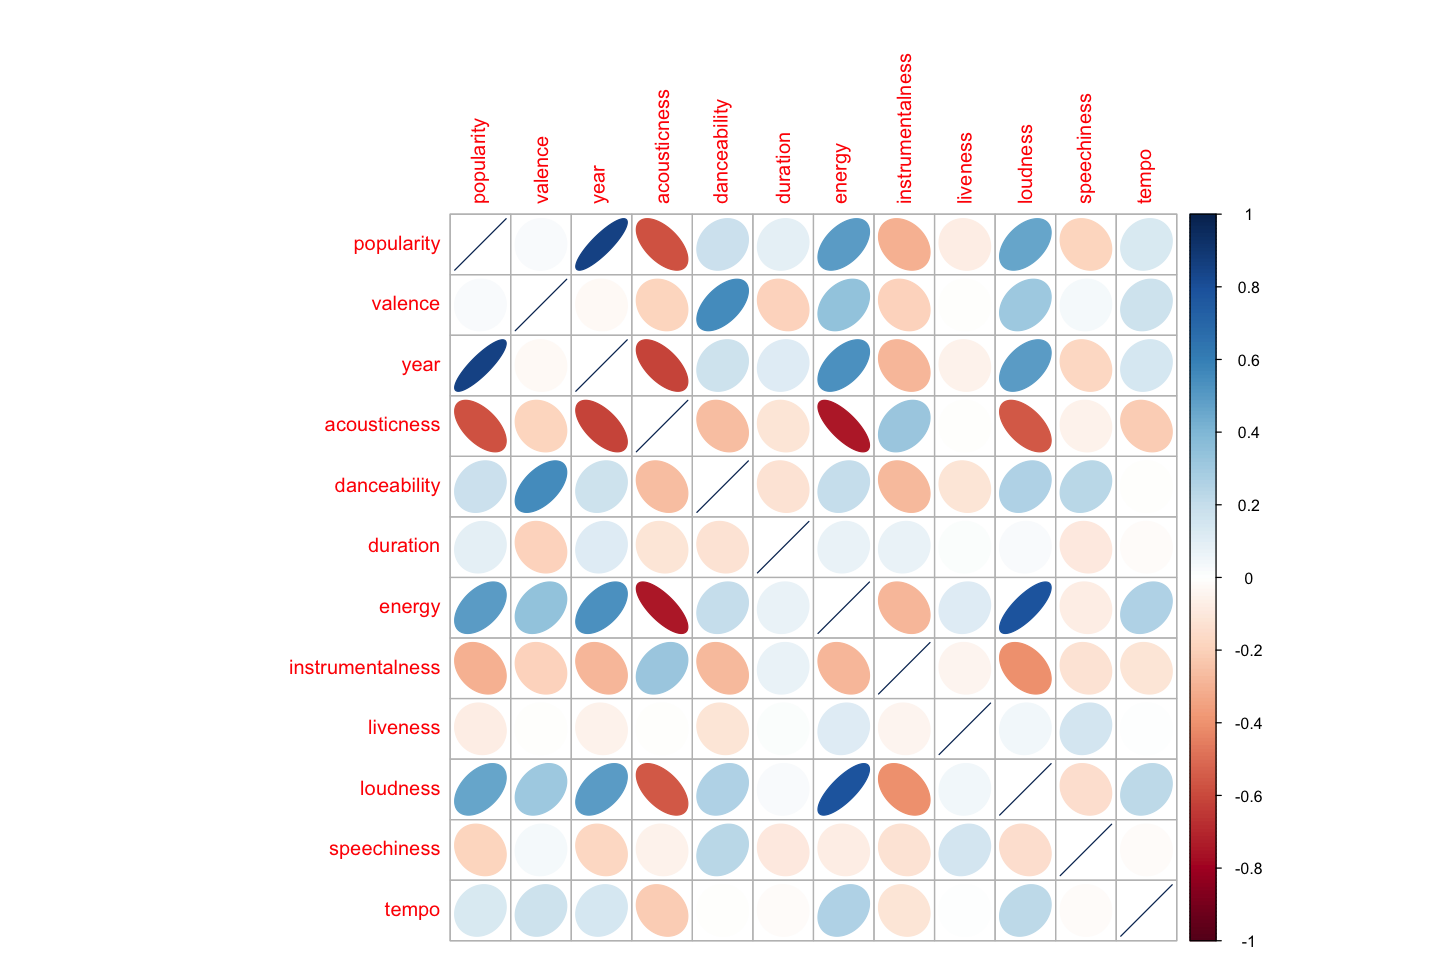

In [12]:
library(corrplot)
cormat <- cor(songs.quant)
corrplot(cormat, method="ellipse")

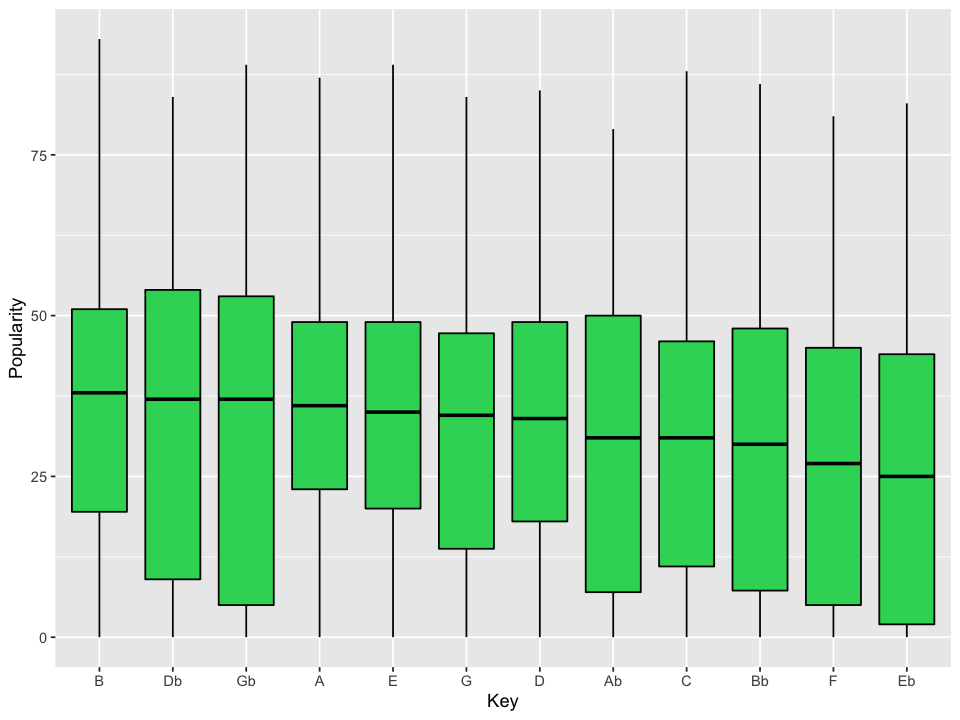

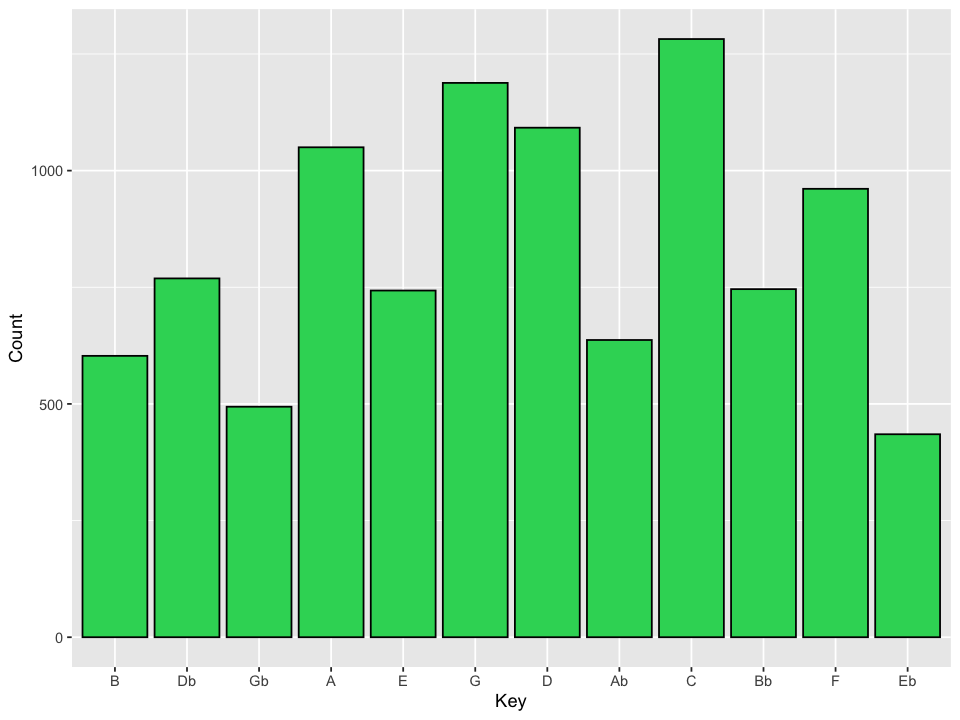

In [154]:
fig(8,6)
songs %>%
ggplot() +
    geom_boxplot(aes(x=reorder(key, -popularity, FUN=median), y=popularity), fill='#2FD565', color='#000000') +
    labs(x='Key', y='Popularity')


songs %>%
ggplot() +
    geom_bar(stat='count', aes(reorder(key, -popularity, FUN=median)), fill='#2FD565', color='#000000') +
    labs(x='Key', y='Count')

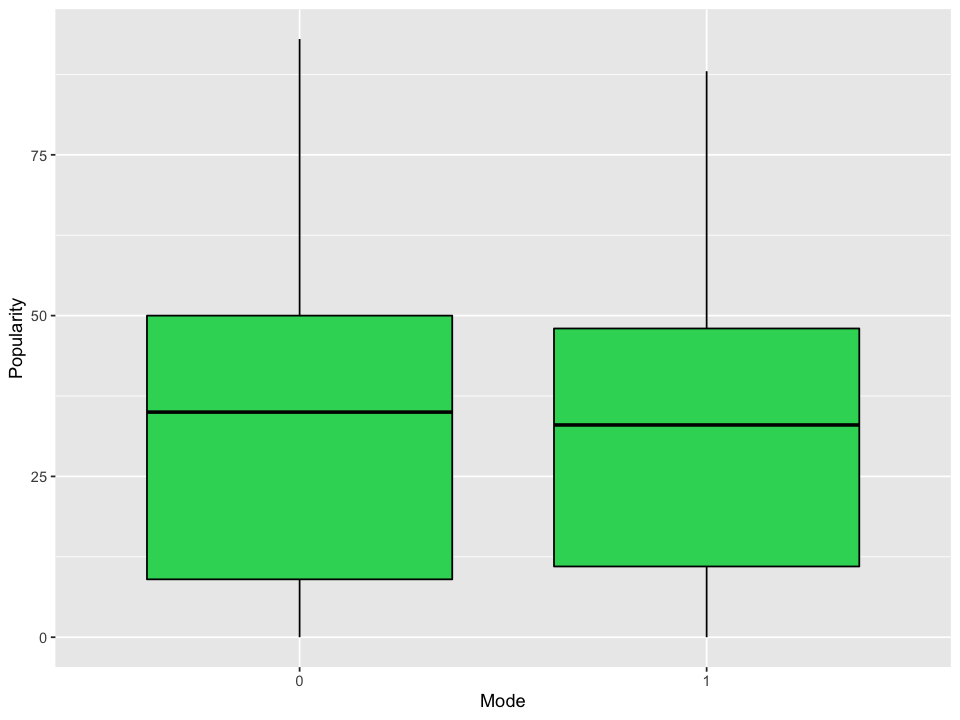

In [52]:
fig(8,6)
songs %>%
ggplot() +
    geom_boxplot(aes(mode, popularity), fill='#2FD565', color='#000000') +
    labs(x='Mode', y='Popularity')

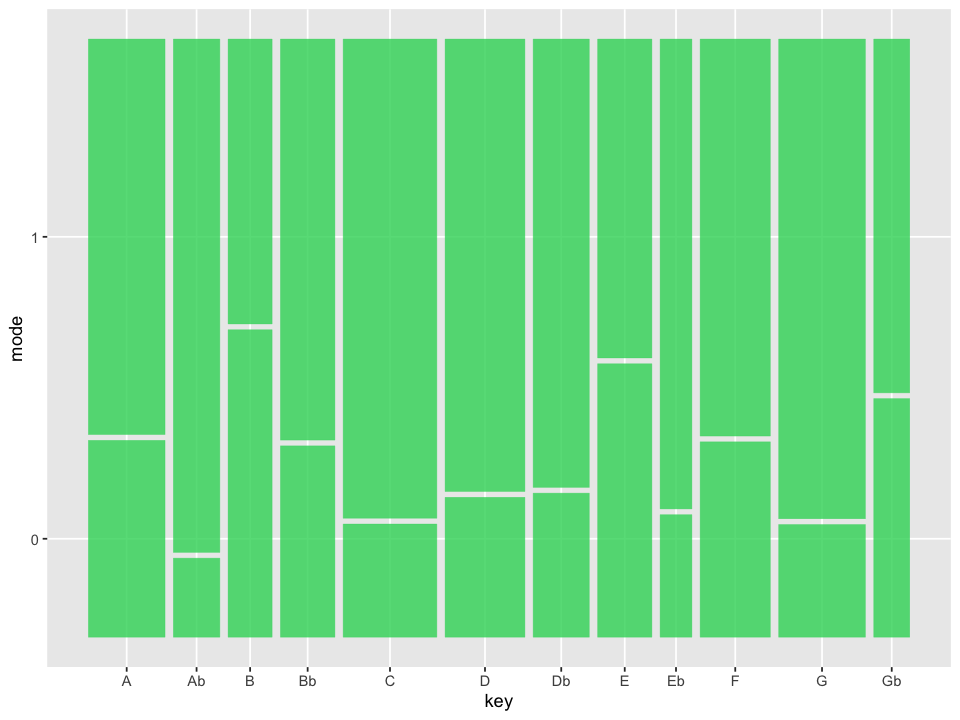

In [168]:
library(ggmosaic)
songs %>%
ggplot() +
    geom_mosaic(aes(product(mode, key)), fill='#2FD565')

## Principal component analysis

In [64]:
library(FactoMineR)
library(factoextra)
res.pca <- songs.quant %>% 
    select(!popularity) %>% 
    PCA(ncp=11)

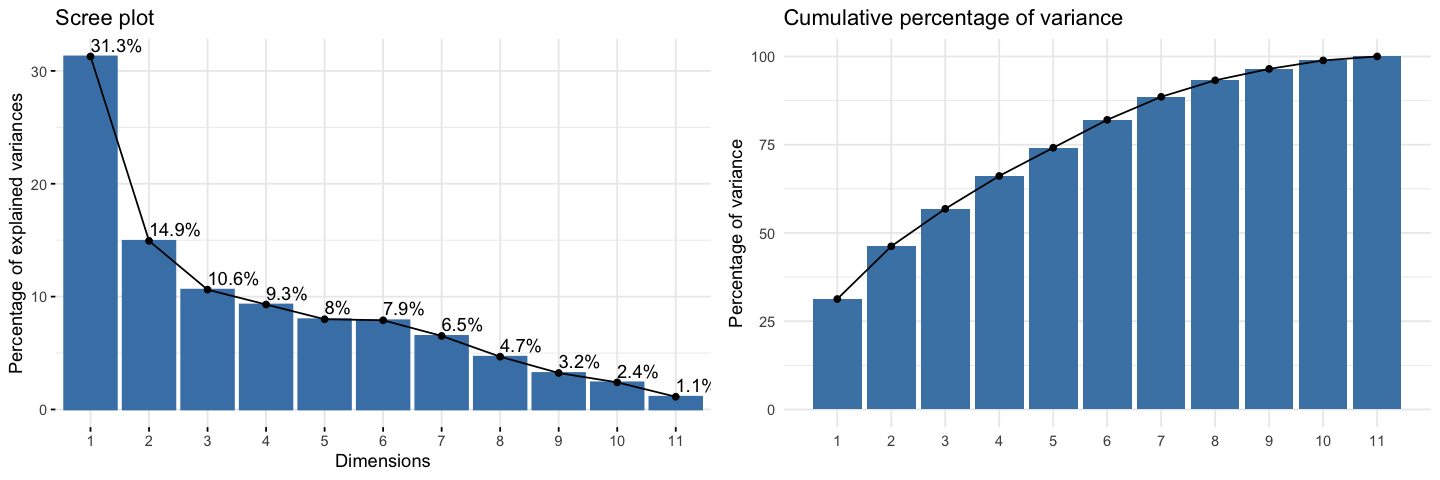

In [65]:
fig(12,4)
g1 <- fviz_eig(res.pca, addlabels=TRUE, ncp=11)

g2 <- tibble(pc=c(1:11), eig=res.pca$eig[1:11,3]) %>%
ggplot(aes(pc, eig)) + 
    geom_bar(stat="identity", fill='#4984B3') +
    geom_line() + 
    geom_point() +
    scale_x_continuous(breaks=c(1:11), minor_breaks=NULL) +
    labs(x='', y='Percentage of variance', title='Cumulative percentage of variance') +
    theme_minimal()

grid.arrange(g1, g2, nrow=1)

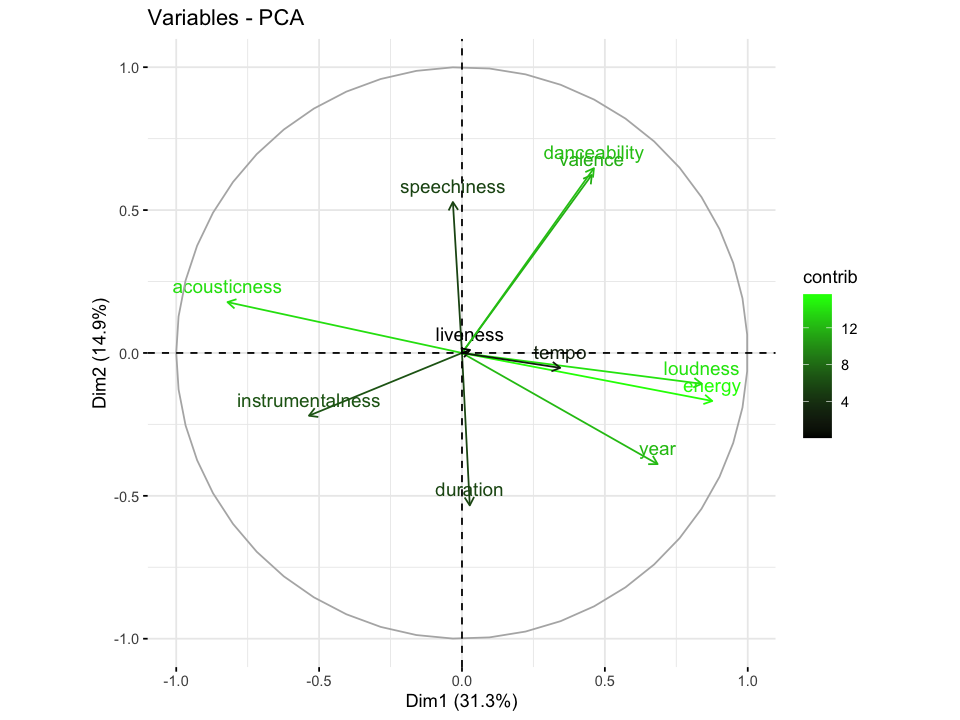

In [66]:
fig(8,6)
fviz_pca_var(res.pca, col.var="contrib") +
    scale_color_gradient(low="black", high="green")

Warning message:
“Removed 12 rows containing missing values (geom_point).”


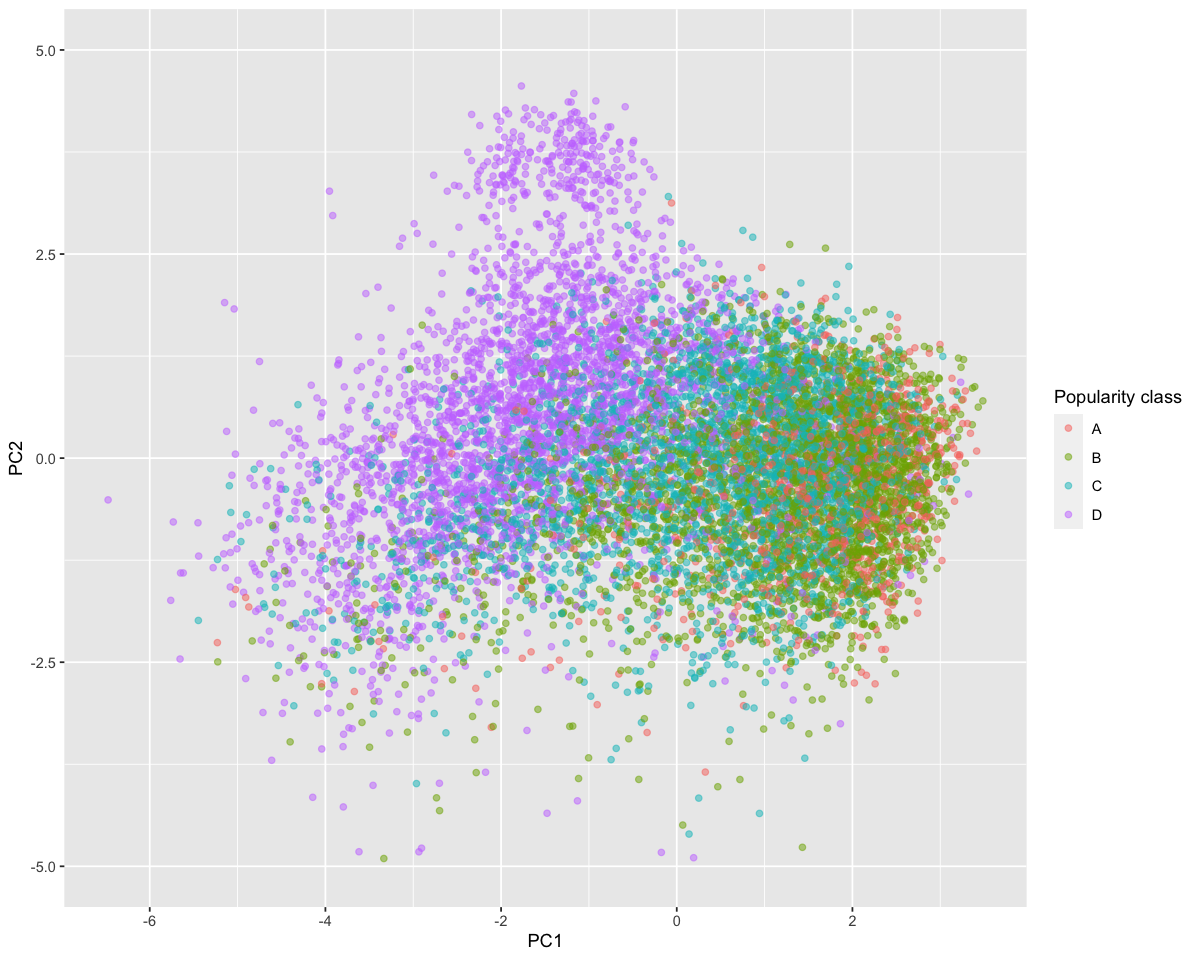

In [70]:
name_func <- function(name) {
    paste('PC', substring(name, first=5), sep='')
}

pca.ind <- as_tibble(res.pca$ind$coord) %>%
    rename_with(name_func, everything()) %>%
    mutate(pop.class=songs$pop.class)

gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}
colors <- gg_color_hue(4)

fig(10,8)
ggplot(pca.ind) + 
    geom_point(aes(x=PC1, y=PC2, color=pop.class), alpha=.5) +
    scale_y_continuous(limits=c(-5,5)) +
    labs(color="Popularity class")

# Classification models

In [186]:
data_split <- songs %>%
    select(!c(popularity, name)) %>%
    initial_split(strata = pop.class, prop = 0.75)

songs_train <- training(data_split)
songs_test <- testing(data_split)

## Logistic regression

In [224]:
library(glmnet)

### Without regularization

In [232]:
log_reg <- multinom_reg(penalty = 0) %>%
    set_engine('glmnet')

In [233]:
log_reg_fit <-
    log_reg %>%
    set_engine('glmnet') %>%
    fit(pop.class ~ ., 
        data=songs_train)

#tidy(log_reg_fit) %>% filter(estimate > 0)

In [234]:
log_reg_results <- 
  songs_test %>%
  select(pop.class) %>%
  bind_cols(
    predict(log_reg_fit, new_data = songs_test %>% select(-pop.class))
  )

In [235]:
log_reg_results %>%
    conf_mat(truth=pop.class, estimate=.pred_class)

log_reg_results %>%
    precision(pop.class, .pred_class)

          Truth
Prediction   A   B   C   D
         A  52  11   2   3
         B 174 500 147  12
         C  23 196 498  70
         D   2   9  90 710

.metric   .estimator .estimate
1 precision macro      0.7182978

### With regularization

In [269]:
log_reg <- multinom_reg(penalty = .004, mixture=1) %>%
    set_engine('glmnet')

In [270]:
log_reg_fit <-
    log_reg %>%
    set_engine('glmnet') %>%
    fit(pop.class ~ ., 
        data=songs_train)

tidy(log_reg_fit) %>% filter(estimate > 0)

class term             estimate     penalty
1  A     year             8.271439e-02 0.004  
2  A     danceability     5.639858e-01 0.004  
3  A     loudness         6.629226e-03 0.004  
4  A     keyDb            8.594376e-02 0.004  
5  B     valence          6.948802e-02 0.004  
6  B     year             3.347356e-02 0.004  
7  B     acousticness     7.800163e-02 0.004  
8  B     duration         2.456924e-07 0.004  
9  B     loudness         1.254095e-02 0.004  
10 C     (Intercept)      3.515809e+01 0.004  
11 C     valence          1.732178e-01 0.004  
12 C     energy           4.491821e-01 0.004  
13 C     liveness         1.457170e-01 0.004  
14 C     mode1            7.152362e-03 0.004  
15 C     keyC             1.571925e-02 0.004  
16 C     keyD             6.731894e-02 0.004  
17 D     (Intercept)      2.587830e+02 0.004  
18 D     acousticness     8.407902e-01 0.004  
19 D     instrumentalness 8.058847e-01 0.004  
20 D     speechiness      2.101715e+00 0.004  
21 D     keyDb            1.990663e-03 0.004  
22 D     keyG             6.805114e-02 0.004

In [271]:
log_reg_results <- 
  songs_test %>%
  select(pop.class) %>%
  bind_cols(
    predict(log_reg_fit, new_data = songs_test %>% select(-pop.class))
  )

In [272]:
log_reg_results %>%
    conf_mat(truth=pop.class, estimate=.pred_class)

log_reg_results %>%
    precision(pop.class, .pred_class)

          Truth
Prediction   A   B   C   D
         A  13   3   2   0
         B 213 512 140  15
         C  23 193 499  62
         D   2   8  96 718

.metric   .estimator .estimate
1 precision macro      0.7044033

In [273]:
log_reg <- multinom_reg(penalty = tune()) %>%
    set_engine('glmnet')

In [274]:
songs_rec <- recipe(pop.class ~ ., data = songs_train)# %>%
  #step_normalize(all_numeric(), -all_outcomes())

songs_prep <- songs_rec %>%
  prep()

In [275]:
lasso_spec <- multinom_reg(penalty = 0.1, mixture = 1) %>%
  set_engine("glmnet")

wf <- workflow() %>%
  add_recipe(songs_rec)

#lasso_fit <- wf %>%
#  add_model(lasso_spec) %>%
#  fit(data = songs_train)

#lasso_fit %>%
#  pull_workflow_fit() %>%
#  tidy()

## SMV

In [277]:
svm_mod <-
  svm_rbf(cost = tune(), rbf_sigma = tune()) %>%
  set_mode("classification") %>%
  set_engine("kernlab")

In [278]:
songs_rec <-
  recipe(pop.class ~ ., data = songs_train)  %>%
  # remove any zero variance predictors
  step_zv(all_predictors()) %>% 
  # remove any linear combinations
  step_lincomb(all_numeric())

In [286]:
songs_rs <- bootstraps(songs_train, times = 5)

In [287]:
roc_vals <- metric_set(roc_auc)
ctrl <- control_grid(verbose = FALSE, save_pred = TRUE)

In [288]:
formula_res <-
  svm_mod %>% 
  tune_grid(
    pop.class ~ .,
    resamples = songs_rs#,
#    metrics = roc_vals,
#    control = ctrl
  )
#formula_res

x Bootstrap1: preprocessor 1/1, model 4/10 (predictions): Error: $ operator is invalid...



In [285]:
formula_res